## Ejemplo 1: Pruebas A/B

### 1. Objetivos:
    - Aprender a evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


El siguiente es un dataset obtenido con los resultados de una Prueba A/B. Se probaron dos flujos de venta distintos y se registró si cada uno de ellos resultó en una conversión (venta) o no. El test A es la hipótesis alternativa (la aplicada al grupo experimental), mientras que el test B es la hipótesis nula (la aplicada al grupo control).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BEDU_DS/FASE_3/Remoto Datasets/Remoto ab_test-sales_pipeline.csv')

df

,test,conversion,no conversion
0,B,0,1
1,A,0,1
2,A,0,1
3,A,0,1
4,A,0,1
...,...,...,...
46322,B,0,1
46323,B,0,1
46324,B,0,1
46325,A,0,1


Lo primero que podemos hacer es agrupar nuestros resultados por 'test', para realizar un conteo de cuántas conversiones hubo con cada flujo de ventas:

In [ ]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()

total_count

,conversion,no conversion
test,,
A,198,23541
B,184,22404


Saquemos la proporción de conversiones que hubo comparadas con el total de pruebas que se realizaron:

In [ ]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])

total_count

,conversion,no conversion,success rate
test,,,
A,198,23541,0.008341
B,184,22404,0.008146


Con estos datos parecería que el flujo A (la hipótesis alternativa) es superior al flujo B. Veamos qué tan superior:

In [ ]:
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100

EN NUESTRA MUESTRA LA ALTERNATIVA LA PRUEBA A TUVO MAS EXITO QUE B. ¿ES CUESTION DE AZAR O ES CIERTO? 

In [ ]:
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más `efectivo que el test B para generar ventas.')

El test A fue 2.34% más `efectivo que el test B para generar ventas.


¿Ahora, podemos entonces concluir que el flujo de ventas A es mejor que el B? No tan rápido. Vamos a aplicar un test de permutación para saber si nuestro hallazgo es estadísticamente significativo.

Primero tenemos que mezclar las mediciones del test A y el B en el mismo DataFrame. Esto ya está hecho, entonces solamente vamos a eliminar la columna 'test' para que no haya manera de diferenciarlos:

In [ ]:
all_measurements = df[['conversion', 'no conversion']]

Ahora necesitamos saber cuántos tests con el flujo A hubieron para poder generar muestras del mismo tamaño exactamente:

In [ ]:
value_counts = df['test'].value_counts()

value_counts

A    23739
B    22588
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.

CREAMOS 1000 COPIAS ALEATORIAS CON EL MISMO TAMAÑO QUE A Y B PARA VER QUE TANTO PODEMOS ESPERAR DEL AZAR Y NO CONFUNDIRLO CON UNA TENDENCIA.

In [ ]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)] #todos los elementos que no estan en el indice de a
    conv_b.append(b['conversion'].sum()) 
    no_conv_b.append(b['no conversion'].sum())

In [ ]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b
0,207,23532,175,22413
1,197,23542,185,22403
2,191,23548,191,22397
3,214,23525,168,22420
4,186,23553,196,22392
...,...,...,...,...
995,210,23529,172,22416
996,207,23532,175,22413
997,187,23552,195,22393
998,188,23551,194,22394


TASA DE EFICIENCIA DE LA PRUEBA A y B. $$a\% = \frac{a}{a+\bar{a}}$$

In [ ]:
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [ ]:
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,207,23532,175,22413,0.008720,0.007747
1,197,23542,185,22403,0.008299,0.008190
2,191,23548,191,22397,0.008046,0.008456
3,214,23525,168,22420,0.009015,0.007438
4,186,23553,196,22392,0.007835,0.008677
...,...,...,...,...,...,...
995,210,23529,172,22416,0.008846,0.007615
996,207,23532,175,22413,0.008720,0.007747
997,187,23552,195,22393,0.007877,0.008633
998,188,23551,194,22394,0.007919,0.008589


In [ ]:
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,207,23532,175,22413,0.008720,0.007747,0.111510
1,197,23542,185,22403,0.008299,0.008190,0.013061
2,191,23548,191,22397,0.008046,0.008456,-0.050956
3,214,23525,168,22420,0.009015,0.007438,0.174950
4,186,23553,196,22392,0.007835,0.008677,-0.107459
...,...,...,...,...,...,...,...
995,210,23529,172,22416,0.008846,0.007615,0.139217
996,207,23532,175,22413,0.008720,0.007747,0.111510
997,187,23552,195,22393,0.007877,0.008633,-0.095917
998,188,23551,194,22394,0.007919,0.008589,-0.084497


Ya tenemos nuestros resultados, vamos a ver dónde cae en nuestra distribución el resultado que obtuvimos en nuestro experimento:

LA EFICIENCIA DE NUESTRA PRUEBA A EN COMPARACION DE B, ES PURA CUESTION DE AZAR AL TENER UN VALOR MUY CERCANO A LA MEDIA DE LAS EFICIENCIAS DE LAS MUESTRAS ALEATORIAS. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


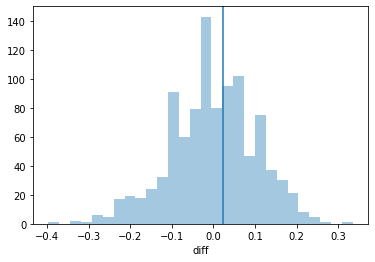

In [ ]:
sns.distplot(perm_results['diff'], kde=False, norm_hist=False)

plt.axvline(diferencia_en_proporcion);

Solamente de ver la histograma podemos concluir que nuestro resultado es de hecho bastante típico. Un gran número de modelos realizados totalmente al azar tuvieron valores iguales o más extremos que el que obtuvimos en nuestro experimento.

Vamos ahora a obtener el Valor P para cuantificar numéricamente nuestro resultado:

In [ ]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.422

Este valor quiere decir que el 41.6% de los test que hicimos obtuvieron un valor igual o más extremo que el obtenido en el experimento. Esto está extremadamente alejado de un Alfa de 5%, y por lo tanto definitivamente nuestro resultado **no es estadísticamente significativo**.

UN BUEN VALOR QUE NO SEA CUESTION DE AZAR Y CON EL CUAL PODAMOS CONCLUIR QUE UNA PRUEBA ES MEJOR QUE OTRA, DEBE SER UN VALOR ATIPICO AL HISTOGRAMA DE EFICIENCIAS DE LAS MUESTRAS ALEATORIAS. 